In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from polyvore_dataset import categoryDataset
from sklearn import metrics
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
%matplotlib inline

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor()
])
img = Image.open('./cat_dog.png').convert('RGB')
img = transform(img)
img = img.unsqueeze(0)

In [3]:
model = models.resnet152(pretrained=True)
model.eval()
score = model(img).data.numpy()
print(np.argsort(score)[0][-5:])
# ImageNet Labels can be found at: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
# 243 is bull mastiff, 282 is tiger cat

[243 753 245 281 282]


In [4]:
target_layer = 'layer4.2'
feat_map = None
grad = None
def func_f(module, input, output):
    print('forward', output.shape)
    global feat_map
    feat_map = output.detach()
    #self.all_fmaps[id(module)] = output.detach()

def func_b(module, grad_in, grad_out):
    print('backward', grad_out[0].shape)
    global grad
    grad = grad_out[0].detach()
    #self.all_grads[id(module)] = grad_out[0].detach()

for m in model.named_modules():
    if m[0] == target_layer:
        print(m)
        m[1].register_forward_hook(func_f)
        m[1].register_backward_hook(func_b)

('layer4.2', Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
))


In [5]:
out = model(img)
one_hot = torch.FloatTensor(1, out.size()[-1]).zero_()
one_hot[0][243] = 1

model.zero_grad()
out.backward(gradient=one_hot, retain_graph=True)

forward torch.Size([1, 2048, 7, 7])
backward torch.Size([1, 2048, 7, 7])


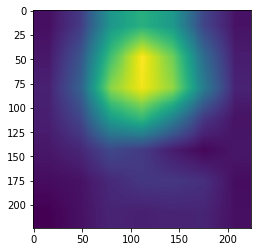

In [6]:
guided_gradients = grad[0].data.numpy()
# Get convolution outputs
target = feat_map[0].data.numpy()
# Get weights from gradients
weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
# Create empty numpy array for cam
cam = np.ones(target.shape[1:], dtype=np.float32)
# Multiply each weight with its conv output and then, sum
for i, w in enumerate(weights):
    cam += w * target[i, :, :]
cam = cv2.resize(cam, (224, 224))
cam = np.maximum(cam, 0)
cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
plt.imshow(cam)
plt.show()

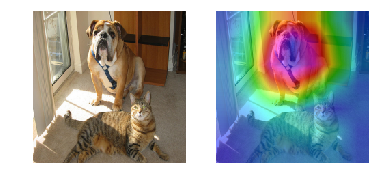

In [25]:
raw_image = cv2.imread('./cat_dog.png')[..., ::-1]
plt.subplot(121)
plt.imshow(raw_image)
plt.axis('off')

heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_HSV)
heatmap = heatmap.astype(np.float) + raw_image.astype(np.float)
heatmap = heatmap / heatmap.max() * 255.0
plt.subplot(122)
plt.imshow(np.uint8(heatmap))
plt.axis('off')

plt.show()